# Assignment 3: Gendered Directions in Embeddings

OBS!

**Since only .ipynb file types are allowed for submission via Canvas, my slides are [here](https://drive.google.com/file/d/19VZlA2-I3eq0y6VGcKUvjY-9fGy9BSPh/view?usp=sharing).**

Load the embedding files for English and Chinese, and load the English-Chinese dictionary from [MUSE](https://github.com/facebookresearch/MUSE#ground-truth-bilingual-dictionaries).

The first two embedding files (that are commented out) are from [Word vectors for 157 languages](https://fasttext.cc/docs/en/crawl-vectors.html) (E. Grave, P. Bojanowski, P. Gupta, A. Joulin, T. Mikolov, Learning Word Vectors for 157 Languages), the default embeddings for this assignment. This notebook works on them as well. The first file is loaded to prove that the same result can be produced with the code in this notebook.

Now, the notebook uses the 3rd and 4th [Aligned word vectors](https://fasttext.cc/docs/en/aligned-vectors.html) (A. Joulin, P. Bojanowski, T. Mikolov, H. Jegou, E. Grave, Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion) so that they can be used for PCA as well.

In [1]:
!wget -N https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# !wget -N https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
!wget -N https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec
!wget -N https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.zh.align.vec
!wget -N https://dl.fbaipublicfiles.com/arrival/dictionaries/en-zh.txt
!wget -N https://dl.fbaipublicfiles.com/arrival/dictionaries/zh-en.txt

--2022-06-13 16:23:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘cc.en.300.vec.gz’ not modified on server. Omitting download.

--2022-06-13 16:23:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘wiki.en.align.vec’ not modified on server. Omitting download.

--2022-06-13 16:23:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.zh.align.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfile

General imports

In [2]:
import numpy as np
from pprint import pprint
from urllib.request import urlopen
from collections import defaultdict

The `Embedding` class:

In [3]:
from tqdm import tqdm
import os.path
import gzip
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class Embedding(object):
  def __init__(self, filename):
    """Embedding loader with methods for comparisons and searching
    
    filename:
      The path of the chosen fasttext embedding data file."""
    assert os.path.exists(filename)
    self.filename = filename
    self.tokens = []
    if os.path.splitext(self.filename)[1] == '.gz':                             #check file type and unzip if needed
      open_file = gzip.open(self.filename, 'rt')
    else:
      open_file = open(self.filename)
    with open_file as f:
      shape = f.readline()                                                      # first line in file is the dimensions
      shape = [int(dim) for dim in shape.split(' ')]
      self.vectors = np.ascontiguousarray(np.zeros((300000, shape[1])))         # we don't need too many tokens for the purpose of this assignment
      for i in tqdm(range(300000)):
        line = f.readline()
        key_vec = line.split(' ', 1)
        self.vectors[i,:] = np.fromstring(key_vec[1], dtype=float, sep=' ')     # all vectors are saved in a 2D array
        self.tokens.append(key_vec[0])                                          # all tokens are stored in a list
    self.token2idx = {token:i for i, token in enumerate(self.tokens)}           # a look-up table for easy access to the vectors

  def __len__(self):
    """Gives the number of tokens in the embedding."""
    return len(self.tokens)

  def __getitem__(self, tokens):
    """Returns the vectors for a token or a list of tokens."""
    if type(tokens) == str:                                                     # a single token
      return self.vectors[self.token2idx[tokens],:].reshape(1, -1)
    vecs = np.empty((len(tokens), self.vectors.shape[1]))                       # a list of tokens
    for i, token in enumerate(tokens):
      vecs[i] = self.vectors[self.token2idx[token],:]
    return vecs


  def __contains__(self, token):
    """Allows a user query if a tokens is in the embedding."""
    return token in self.tokens

  def projection(self, direction, vectors):
    """The cosine similarity between a reference direction and a matrix of word vectors.
    
    direction:
      A vector
    vectors:
      A row matrix with word vectors"""
    if vectors.ndim == 1:                                                       # has to reshape if it contains the vector of a single token
      vectors = vectors.reshape(1, -1)
    return cosine_similarity(direction.reshape(1, -1), vectors)
    
  def simple_analogy(self, pair, query, k=5):
    """Simple/Classic word analogy as: man - woman = king - queen"""
    analogous_vec = self[query]-self[pair[0]]+self[pair[1]]
    sims = cosine_similarity(self.vectors, analogous_vec.reshape(1, -1))
    sims_tokens = list(zip(sims, self.tokens))
    sims_tokens.sort(key=lambda x:x[0], reverse=True)                           # rank by cos similarity
    return [token for sim, token in sims_tokens[:k]]


  def similarity(self, token1, token2):     
    """Returns the cosine similarity between two tokens."""
    return cosine_similarity(self[token1], self[token2])

  def analogies(self, analogy_direction, tokens, dist=1):
    """The more complex word analogy method""" 
    results = []
    for x in tqdm(tokens):
      if self.projection(analogy_direction, self[x]) > 0:                       # assuming all professions are to some extent gender biased, 
        highest_sim = 0                                                         # if direction is a -> b (e.g. man -> woman), only pick professions 
        analogy = None                                                          # with a tendency to 'a' (e.g. man) to start comparing
        for y in tokens:
          if euclidean_distances(self[x], self[y]) <= dist:
            sim = cosine_similarity(analogy_direction.reshape(1, -1), self[x]-self[y])
            if sim > highest_sim:
              highest_sim = sim
              analogy = y
        if analogy:
          results.append((x, analogy))
    return results


Create the embedding object, and take a look at some of its tokens.

In [4]:
embedding = Embedding("wiki.en.align.vec")

assert embedding.similarity('cat', 'dog') >= embedding.similarity('cat', 'cow')

print(embedding.tokens[:20])

100%|██████████| 300000/300000 [00:29<00:00, 10126.36it/s]


[',', '.', 'the', '</s>', 'of', '-', 'in', 'and', "'", ')', '(', 'to', 'a', 'is', 'was', 'on', 's', 'for', 'as', 'by']


Do the same for Chinese. (猫, 狗, 牛 == cat, dog, cow)

In [5]:
zh_embedding = Embedding("wiki.zh.align.vec")

assert zh_embedding.similarity('猫', '狗') >= zh_embedding.similarity('猫', '牛')

print(zh_embedding.tokens[:20])

100%|██████████| 300000/300000 [00:22<00:00, 13441.49it/s]


['</s>', '，', '的', '。', '-', '年', "'", '（', '）', '}', '、', '.', '月', ')', '(', '日', '在', '：', '是', ',']


Create a English-Chinese Dictionary and another one in the other direction for better reference. The dictionary uses traditional characters, but both traditional and simplified are in the embeddings. Some conversion functions are built for that.

In [6]:
!pip install hanziconv
!pip install langid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from hanziconv import HanziConv
import langid

def to_simp(simplified):
  return HanziConv.toSimplified(simplified)

def to_trad(traditional):
  return HanziConv.toTraditional(traditional)
  
en2zh = defaultdict(list)
with open('en-zh.txt') as f:
  for line in f.readlines():
    pair = line.split(' ')
    en2zh[pair[0]].append(to_simp(pair[1].rstrip('\n')))

reverse_en2zh = defaultdict(list)     # better reference when converting Chinese professions back to English
for en, zh in en2zh.items():
  for word in zh:
    reverse_en2zh[word] = en

zh2en = defaultdict(list)
with open('zh-en.txt') as f:
  for line in f.readlines():
    pair = line.split(' ')
    zh2en[to_simp(pair[0])].append(pair[1].rstrip('\n'))

## Word analogies

The original examples are removed, and three analogies are presented below:
1. Country in continent (akin to the capital city analogy) - Japan in Asia is similar to which country in Europe? (Germany/France/Belgium in results)
2. Find a noun with an adjective - The rich live in mansions, where do the poor live? ('poorhouse', 'almshouse' in results)
3. Find an adjective with a noun - The ceiling is high, the floor is what? ('low' in results)

In [8]:
pair_query = [(('asia', 'europe'), 'japan'), (('rich', 'mansion'), 'poor'), (('ceiling', 'high'), 'floor')]
for pair, query in pair_query:
  best_matches = embedding.simple_analogy(pair, query, k=5)
  print(f"Matches for the pair {pair} and query '{query}' (in order of similarity):")
  for i, token in enumerate(best_matches):
    print(i+1, token)
  print()

Matches for the pair ('asia', 'europe') and query 'japan' (in order of similarity):
1 japan
2 europe
3 germany
4 france
5 belgium

Matches for the pair ('rich', 'mansion') and query 'poor' (in order of similarity):
1 mansion
2 poorhouse
3 dilapidation
4 almshouse
5 dilapidated

Matches for the pair ('ceiling', 'high') and query 'floor' (in order of similarity):
1 high
2 low
3 floor
4 grades
5 middle/high



Can we produce the same results in Chinese?

In [9]:
pair_query = [(('亞洲', '欧洲'), '日本'), (('富有', '大屋'), '贫穷'), (('天花板', '高'), '地板')]
for pair, query in pair_query:
  best_matches = zh_embedding.simple_analogy(pair, query, k=5)
  print(f"Matches for the pair {pair} and query {query} (in order of similarity):")
  for i, token in enumerate(best_matches):
    print(i+1, token, zh2en[token])
  print()

Matches for the pair ('亞洲', '欧洲') and query 日本 (in order of similarity):
1 日本 ['japan']
2 欧洲 ['europe', 'european']
3 英国 ['england', 'uk']
4 西欧 []
5 国外 ['overseas', 'abroad']

Matches for the pair ('富有', '大屋') and query 贫穷 (in order of similarity):
1 大屋 []
2 钱坑 []
3 农舍 ['farmhouse']
4 后巷 []
5 乡下 ['countryside']

Matches for the pair ('天花板', '高') and query 地板 (in order of similarity):
1 高 ['high', 'tall', 'gao']
2 低 ['lower', 'low']
3 ， []
4 宇 ['woo']
5 ； []



We get a different country (the UK) in the first set of results.

The second and third set of results have produced what we expected ('farmhouse', 'low')

## Finding the genderedness of professions

Download the data for professions from Bulokbasi (2016). We then find the genderedness for our embedding and plot against their survey data.

In [10]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


In [11]:
'congresswoman' in professions

False

Find the Chinese equivalent of the professions, if the profession is in the dictionary. Assign the same stereotypical and definitional values.

In [12]:
zh_professions = {}
en_zh = defaultdict(list)                               # just to take a look of what translations we got
for k, v in professions.items():
  for translation in en2zh[k]:
    if langid.classify(translation)[0] == 'zh':         # we just want Chinese translations (the Chinese dictionary might return English tokens)
      zh_professions[translation] = v                   # each translation gets stored as a 'different' profession, so that we get information
      en_zh[k].append(translation)                      # from the vectors of all possible translations


In [13]:
pprint(en_zh)

defaultdict(<class 'list'>,
            {'accountant': ['会计', '会计师'],
             'acquaintance': ['相识', '熟人'],
             'actor': ['男主角', '演员'],
             'actress': ['女主角', '女演员', '演员'],
             'administrator': ['署长'],
             'advocate': ['鼓吹', '主张', '倡导'],
             'aide': ['助手'],
             'archaeologist': ['考古学家'],
             'archbishop': ['大主教'],
             'architect': ['建筑师'],
             'artist': ['艺术家', '艺人'],
             'artiste': ['艺人'],
             'assassin': ['刺客'],
             'astronomer': ['天文学家'],
             'athlete': ['运动员'],
             'author': ['作者'],
             'baker': ['贝克'],
             'banker': ['庄'],
             'barber': ['理发师', '理发'],
             'baron': ['男爵'],
             'bartender': ['酒保'],
             'bishop': ['主教'],
             'bodyguard': ['保镖'],
             'boss': ['老板'],
             'boxer': ['拳手', '拳击手'],
             'broker': ['经纪人', '经纪', '中介'],
             'bureaucrat': ['官僚'],
     

As shown above, there are several possible translations for each profession, and not all translations are accurate. 
Some are ambiguous: 'director' can be a high-ranking position in an institution or a movie director.
Some translations are not professions: the translation for 'comic' means the comic book itself instead of the person who draws the comics.
Most are good enough, so we will go through the list and use all translations that have an embedding.

We create a woman-man direction.

In [14]:
direction = embedding['man']-embedding['woman']
titles = [title for title in professions.keys() if title in embedding]
projection = embedding.projection(direction, embedding[titles])

Do that for Chinese as well. 

In [15]:
zh_direction = zh_embedding['男人']-zh_embedding['女人']
zh_titles = [title for title in zh_professions.keys() if title in zh_embedding]
zh_projection = zh_embedding.projection(zh_direction, zh_embedding[zh_titles])

Get multiple definitional pairs from Bulokbasi (2016) to improve our estimation of gender directions.


In [16]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

Let's take a look at how that would translate to in Chinese.

In [17]:
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  zh_definitional_pairs = [(en2zh[m], en2zh[f]) for m, f in json.load(remote_file)]
zh_definitional_pairs

[(['女人', '女', '女子'], ['人', '男人', 'man']),
 (['女生', '姑娘', '女孩', 'girl'], ['boy', '男孩']),
 (['她'], []),
 (['母后', '母亲'], ['父亲', '神父', '父']),
 (['女儿'], ['儿子']),
 (['加仑'], ['guy']),
 (['女', '女性'], ['男性', '男']),
 (['她的'], ['他的']),
 ([], []),
 ([], [])]

That's not pretty, nor is the order of possible translations useful. I manually sort the useful definitional pairs.

In [18]:
zh_definitional_pairs = [('女人', '男人'),
 ('女孩', '男孩'),
 ('她', '他'),
 ('母亲', '父亲'),
 ('女兒', '兒子'),
 ('女性', '男性'),
 ('女', '男')]

Form our direction and projection with the above pairs.

In [19]:
direction2 = np.zeros(embedding['man'].shape)
for female, male in definitional_pairs:
  direction2 += embedding[male.lower()]
  direction2 -= embedding[female.lower()]

projection2 = embedding.projection(direction2, embedding[titles])

Form a direction and a projection with the Chinese pairs as well.

In [20]:
zh_direction2 = np.zeros(zh_embedding['男人'].shape)
for female, male in zh_definitional_pairs:
  zh_direction2 += zh_embedding[male]
  zh_direction2 -= zh_embedding[female]

zh_projection2 = zh_embedding.projection(zh_direction2, zh_embedding[zh_titles])

Plot the relation between genderedness in the data and human annotation.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(stereo_or_def, proj1, proj2, en_or_zh):
  fig = plt.figure(figsize=(12, 5))
  ax = fig.subplots(1, 2)
  if en_or_zh == 'en':
    stereo_or_def_quality = [professions[title][stereo_or_def] for title in titles]
  else:
    stereo_or_def_quality = [zh_professions[to_simp(title)][stereo_or_def] for title in zh_titles]
  sns.regplot(x=proj1, y=stereo_or_def_quality, ax=ax[0])
  a = sns.regplot(x=proj2, y=stereo_or_def_quality, ax=ax[1])
  ax[0].set_xlabel("Projection (one pair)")
  ax[1].set_xlabel("Projection (several pairs)")
  if stereo_or_def == 'stereotypical':
    ax[0].set_ylabel("Human labelled stereotypicality")
  else:
    ax[0].set_ylabel("Human labelled definitional genderedness")
  fig.tight_layout(pad=.5)
  fig.show()

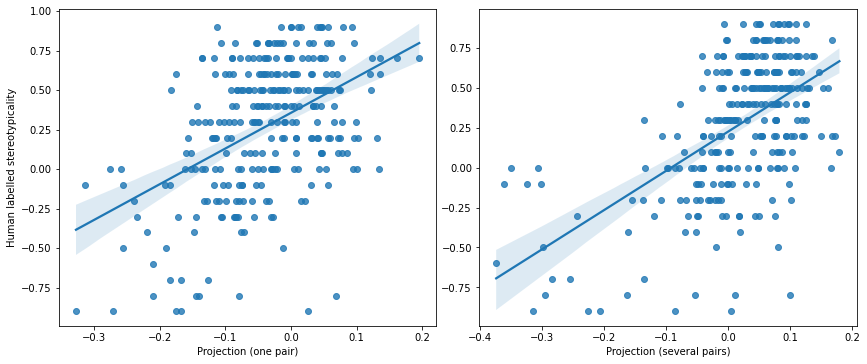

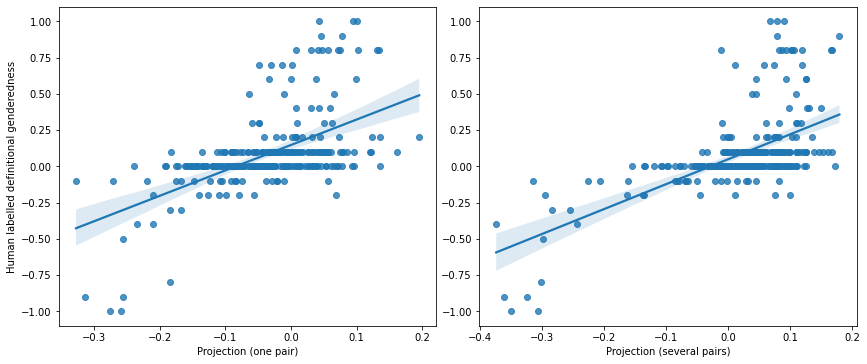

In [22]:
plot('stereotypical', projection, projection2, 'en')
plot('definitional', projection, projection2, 'en')

Plot genderedness for our Chinese data.

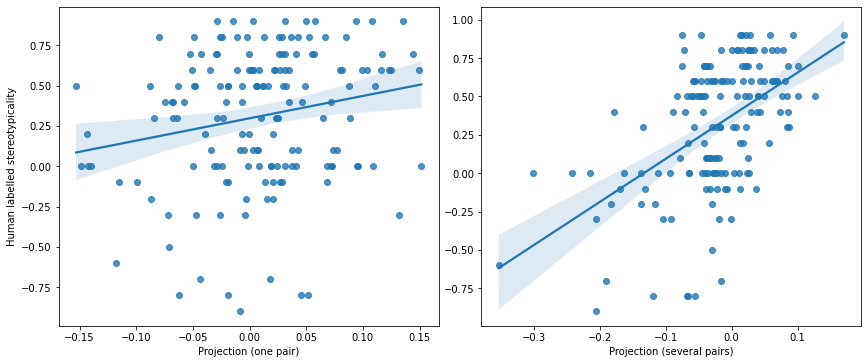

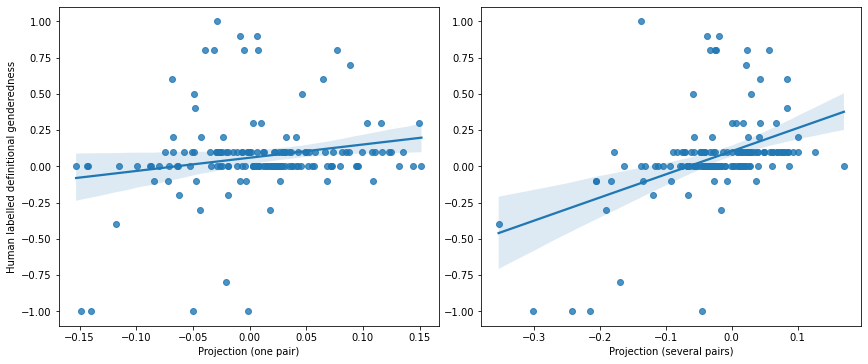

In [23]:
plot('stereotypical', zh_projection, zh_projection2, 'zh')
plot('definitional', zh_projection, zh_projection2, 'zh')

## More analogies

This section uses the more advanced procedure for analogies from Bolukbasi et al. (2016):
$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

The method returns a list of tuples, where the first item of each tuple is a 'male profession' (precisely, professions that have a positive projection relative to the reference direction. Refer to comments for the `analogies` method), and the second item is the female counterpart from our dataset.

Using the aligned vectors produce results that look (at least a bit) different from what was produced in the original assignment notebook (vectors from Common Crawl and Wikipedia with Fasttext). The following two blocks of code use the (non-aligned) embeddings originally provided just to demonstrate this notebook's ability to produce the same results as expected.

In [24]:
nonaligned_embedding = Embedding("cc.en.300.vec.gz")

nonaligned_direction2 = np.zeros(nonaligned_embedding['man'].shape)
for female, male in definitional_pairs:
  nonaligned_direction2 += nonaligned_embedding[male.lower()]
  nonaligned_direction2 -= nonaligned_embedding[female.lower()]

nonaligned_titles = [title for title in professions.keys() if title in nonaligned_embedding]

100%|██████████| 300000/300000 [00:21<00:00, 13924.44it/s]


In [25]:
nonaligned_embedding.analogies(analogy_direction=nonaligned_direction2, tokens=nonaligned_titles)

100%|██████████| 291/291 [00:24<00:00, 12.09it/s]


[('accountant', 'businesswoman'),
 ('acquaintance', 'businesswoman'),
 ('actor', 'actress'),
 ('administrator', 'actress'),
 ('adventurer', 'businesswoman'),
 ('advocate', 'actress'),
 ('alderman', 'businesswoman'),
 ('ambassador', 'actress'),
 ('analyst', 'businesswoman'),
 ('anthropologist', 'actress'),
 ('archaeologist', 'actress'),
 ('archbishop', 'businesswoman'),
 ('architect', 'businesswoman'),
 ('artist', 'actress'),
 ('artiste', 'actress'),
 ('assassin', 'businesswoman'),
 ('astronaut', 'businesswoman'),
 ('astronomer', 'actress'),
 ('athlete', 'businesswoman'),
 ('attorney', 'paralegal'),
 ('author', 'businesswoman'),
 ('ballplayer', 'businesswoman'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'actress'),
 ('bartender', 'waitress'),
 ('biologist', 'businesswoman'),
 ('bishop', 'parishioner'),
 ('bodyguard', 'actress'),
 ('bookkeeper', 'homemaker'),
 ('broadcaster', 'actress'),
 ('broker', 'consultant'),
 ('bureaucrat', 'businesswoman'),
 ('busine

Linguistic gender counterparts are shown ('actor': 'actress', 'businessman': 'businesswoman', 'waiter': 'waitress'). At the same time, the pairs are dominated by 'businesswoman' and 'actress'. 

The results above are created according to the conditions of the given equation, where $\parallel \overrightarrow{x}-\overrightarrow{y} \parallel = \delta$ in Bolukbasi et al. (2016): 'The intuition of the scoring metric is that we want a good analogy pair to be close to parallel to the seed direction while the two words are not too far apart in order to be semantically coherent. The parameter δ sets the threshold for semantic similarity.' (p. 8). They claim that the decision of $\delta = 1$ is because 'it often works well in practice'. Below, the analogy is run again with a higher and a lower threshold to re-evaluate semantic similarity.



In [26]:
# a lower threshold (higher δ)

nonaligned_embedding.analogies(analogy_direction=nonaligned_direction2, tokens=nonaligned_titles, dist=1.5)

100%|██████████| 291/291 [00:35<00:00,  8.29it/s]


[('accountant', 'businesswoman'),
 ('acquaintance', 'businesswoman'),
 ('actor', 'actress'),
 ('administrator', 'actress'),
 ('adventurer', 'businesswoman'),
 ('advocate', 'actress'),
 ('aide', 'nurse'),
 ('alderman', 'actress'),
 ('ambassador', 'actress'),
 ('analyst', 'actress'),
 ('anthropologist', 'actress'),
 ('archaeologist', 'actress'),
 ('archbishop', 'businesswoman'),
 ('architect', 'businesswoman'),
 ('artist', 'actress'),
 ('artiste', 'actress'),
 ('assassin', 'actress'),
 ('astronaut', 'actress'),
 ('astronomer', 'actress'),
 ('athlete', 'actress'),
 ('attorney', 'paralegal'),
 ('author', 'actress'),
 ('baker', 'homemaker'),
 ('ballplayer', 'businesswoman'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('baron', 'actress'),
 ('barrister', 'actress'),
 ('bartender', 'waitress'),
 ('biologist', 'actress'),
 ('bishop', 'actress'),
 ('bodyguard', 'actress'),
 ('bookkeeper', 'actress'),
 ('boss', 'businesswoman'),
 ('boxer', 'actress'),
 ('broadcaster', 'actress'),

In [27]:
# a higher threshold (lower δ)

nonaligned_embedding.analogies(analogy_direction=nonaligned_direction2, tokens=nonaligned_titles, dist=0.65)     # dist=0.5 leaves no trace of businesswoman and actress

100%|██████████| 291/291 [00:12<00:00, 23.71it/s]


[('accountant', 'businesswoman'),
 ('acquaintance', 'businesswoman'),
 ('administrator', 'businesswoman'),
 ('adventurer', 'businesswoman'),
 ('advocate', 'consultant'),
 ('alderman', 'councilman'),
 ('ambassador', 'consultant'),
 ('anthropologist', 'businesswoman'),
 ('archaeologist', 'businesswoman'),
 ('archbishop', 'parliamentarian'),
 ('architect', 'consultant'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('attorney', 'paralegal'),
 ('ballplayer', 'sportswriter'),
 ('barrister', 'solicitor'),
 ('bartender', 'waitress'),
 ('biologist', 'epidemiologist'),
 ('bodyguard', 'housekeeper'),
 ('bookkeeper', 'businesswoman'),
 ('broadcaster', 'businesswoman'),
 ('bureaucrat', 'environmentalist'),
 ('businessman', 'businesswoman'),
 ('cameraman', 'photojournalist'),
 ('campaigner', 'businesswoman'),
 ('captain', 'commander'),
 ('cardiologist', 'receptionist'),
 ('caretaker', 'receptionist'),
 ('carpenter', 'electrician'),
 ('cartoonist', 'illustrator'),
 ('cellist', 'vio

As δ goes higher, the female professions tend towards being either actress or businesswoman. On the other hand, when δ is lowered, we get more semantics-specific results, and there is more for us to interpret in the data. In other words, if we allow a low semantic coherence, the embeddings for 'businesswoman' and 'actress' (for this pre-trained embedding set) relative to all professions have the highest cosine similarity (i.e. the direction is closest to parallel to our reference direction 'boy -> girl'). 
At the same time, if the Euclidean distance is too short, even a high cosine similarity between two professions does not inform us much on genderedness; it may just be that a profession is, for whatever reason, 'less male' (e.g. from the results above, 'carpenter': 'electrician', but 'electrician' still has a male tendency).

Based on this, I would like to suggest that we should establish a method to seek an optimal threshold for each particular pre-trained set of embeddings before we start looking for conclusive patterns. That being said, we could still find some speculative patterns from the above results where `dist=0.65`, for example female counterparts are often more human-oriented than the male professions: 'columnist': 'consultant', 'geologist': 'anthropologist', 'inventor': 'philanthropist' etc.

### With aligned embeddings

Below, we do the same experiment, but with our aligned embeddings.

In [28]:
embedding.analogies(analogy_direction=direction2, tokens=titles)

100%|██████████| 292/292 [00:08<00:00, 35.57it/s]


[('accountant', 'businesswoman'),
 ('actor', 'actress'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'protagonist'),
 ('aide', 'counselor'),
 ('alderman', 'solicitor'),
 ('ambassador', 'secretary'),
 ('analyst', 'columnist'),
 ('archbishop', 'parishioner'),
 ('architect', 'painter'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('attorney', 'paralegal'),
 ('author', 'novelist'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'campaigner'),
 ('bartender', 'waitress'),
 ('bishop', 'parishioner'),
 ('bookkeeper', 'waitress'),
 ('boss', 'bartender'),
 ('boxer', 'wrestler'),
 ('broadcaster', 'columnist'),
 ('broker', 'realtor'),
 ('businessman', 'businesswoman'),
 ('butcher', 'hairdresser'),
 ('butler', 'baker'),
 ('cameraman', 'photojournalist'),
 ('captain', 'officer'),
 ('caretaker', 'housekeeper'),
 ('cartoonist', 'novelist'),
 ('chancellor', 'secretary'),
 ('chaplain', 'lecturer'),
 ('character', 'protagonist'),
 ('chemist', 'pediatrici

We get the linguistic equivalences ('monk and 'nun' as well). There is a similar pattern of human-orientedness as well. Another pattern emerges: moving from a more 'male-like' profession in the 'male -> female' direction usually leads us to a lower ranking position: 'bishop': 'parishioner', 'scholar': 'librarian', 'councilor': 'secretary', 'physician': 'nurse' etc.

We try to do the same for Chinese. Results will look different not only because of different biases in the Chinese dataset, but we might also be losing information/seeing bias when translating. For example, 'businesswoman' isn't in our dictionary. There is nearly no gender specifications in morphology, so Chinese uses the same term '商人' for both 'businessman' and 'businesswoman', but our dictionary does not even create an entry for the latter.

In [29]:
print(en2zh['businessman'])
print(en2zh['businesswoman'])

['商人']
[]


In [30]:
zh_analogies = zh_embedding.analogies(analogy_direction=zh_direction2, tokens=zh_titles)
zh_analogies_trans = [(reverse_en2zh[m], reverse_en2zh[f]) for m, f in zh_analogies]

pprint([pair for pair in zip(zh_analogies, zh_analogies_trans)])

100%|██████████| 161/161 [00:01<00:00, 92.47it/s]

[(('熟人', '画家'), ('acquaintances', 'painters')),
 (('男主角', '女主角'), ('actor', 'heroine')),
 (('大主教', '圣人'), ('archbishop', 'saints')),
 (('刺客', '保镖'), ('assassins', 'bodyguard')),
 (('贝克', '圣'), ('baker', 'saint')),
 (('主教', '圣'), ('bishop', 'saint')),
 (('老板', '女佣'), ('boss', 'maid')),
 (('拳手', '作家'), ('boxer', 'writers')),
 (('官僚', '管理者'), ('bureaucracy', 'managers')),
 (('商人', '业主'), ('businessmen', 'landlord')),
 (('屠夫', '保镖'), ('butcher', 'bodyguard')),
 (('队长', '护士'), ('captain', 'nurse')),
 (('木匠', '保姆'), ('carpenters', 'nanny')),
 (('木工', '大厨'), ('woodworking', 'chef')),
 (('市民', '公民'), ('citizen', 'civic')),
 (('教士', '水手'), ('cleric', 'sailor')),
 (('教练', '教师'), ('coach', 'teachers')),
 (('漫画', '主人公'), ('cartoons', 'protagonist')),
 (('司令', '主任'), ('commander', 'director')),
 (('作曲家', '女演员'), ('composers', 'actresses')),
 (('指挥', '独唱'), ('conductor', 'soloist')),
 (('警探', '保镖'), ('detective', 'bodyguard')),
 (('博士', '医生'), ('doctor', 'doctor')),
 (('鼓手', '歌手'), ('drummer', 'sing

The results may be a bit constricted. We can try lowering our threshold a bit.

In [31]:
zh_analogies = zh_embedding.analogies(analogy_direction=zh_direction2, tokens=zh_titles, dist=1.1)
zh_analogies_trans = [(reverse_en2zh[m], reverse_en2zh[f]) for m, f in zh_analogies]

pprint([pair for pair in zip(zh_analogies, zh_analogies_trans)])

100%|██████████| 161/161 [00:02<00:00, 65.01it/s]

[(('熟人', '女佣'), ('acquaintances', 'maid')),
 (('男主角', '女主角'), ('actor', 'heroine')),
 (('大主教', '总统'), ('archbishop', 'president')),
 (('刺客', '保姆'), ('assassins', 'nanny')),
 (('贝克', '主妇'), ('baker', 'housewife')),
 (('男爵', '管家'), ('baron', 'housekeeper')),
 (('主教', '圣'), ('bishop', 'saint')),
 (('老板', '女佣'), ('boss', 'maid')),
 (('拳手', '歌手'), ('boxer', 'singers')),
 (('官僚', '品格'), ('bureaucracy', 'character')),
 (('商人', '女佣'), ('businessmen', 'maid')),
 (('屠夫', '女佣'), ('butcher', 'maid')),
 (('队长', '护士'), ('captain', 'nurse')),
 (('木匠', '女佣'), ('carpenters', 'maid')),
 (('木工', '主妇'), ('woodworking', 'housewife')),
 (('市民', '品格'), ('citizen', 'character')),
 (('教士', '护士'), ('cleric', 'nurse')),
 (('教练', '护士'), ('coach', 'nurse')),
 (('漫画', '女佣'), ('cartoons', 'maid')),
 (('司令', '秘书'), ('commander', 'secretary')),
 (('作曲家', '女演员'), ('composers', 'actresses')),
 (('指挥', '独唱'), ('conductor', 'soloist')),
 (('警探', '女佣'), ('detective', 'maid')),
 (('博士', '护士'), ('doctor', 'nurse')),
 (('鼓手',

We see similar patterns in our Chinese results:
* a lot of 'nurse', 'maid' and 'housewife'
* female results are often lower ranking

The above list is produced again, but in the opposite direction. Now, a positive number in the gender direction indicates a female tendency, and we only start comparing with 'female-inclined' professions.

In [32]:
direction3 = np.zeros(embedding['woman'].shape)
for female, male in definitional_pairs:
  direction3 -= embedding[male.lower()]
  direction3 += embedding[female.lower()]

embedding.analogies(analogy_direction=direction3, tokens=titles)

100%|██████████| 292/292 [00:04<00:00, 65.34it/s]


[('actress', 'actor'),
 ('advocate', 'lawyer'),
 ('anthropologist', 'historian'),
 ('archaeologist', 'historian'),
 ('artist', 'cartoonist'),
 ('artiste', 'entertainer'),
 ('astronaut', 'scientist'),
 ('athlete', 'sportsman'),
 ('baker', 'butler'),
 ('ballerina', 'soloist'),
 ('biologist', 'physicist'),
 ('businesswoman', 'businessman'),
 ('cabbie', 'policeman'),
 ('campaigner', 'politician'),
 ('cardiologist', 'physicist'),
 ('cellist', 'trumpeter'),
 ('choreographer', 'actor'),
 ('columnist', 'commentator'),
 ('correspondent', 'commentator'),
 ('counselor', 'aide'),
 ('curator', 'naturalist'),
 ('dancer', 'actor'),
 ('dentist', 'businessman'),
 ('dermatologist', 'physicist'),
 ('doctor', 'surgeon'),
 ('educator', 'businessman'),
 ('employee', 'janitor'),
 ('entertainer', 'actor'),
 ('environmentalist', 'naturalist'),
 ('epidemiologist', 'physicist'),
 ('hairdresser', 'salesman'),
 ('handyman', 'salesman'),
 ('homemaker', 'businessman'),
 ('housekeeper', 'waiter'),
 ('housewife', 'sal

We can see similar trends in ranks and human-orientedness in the resulting male professions. Let's see what the professions tend towards if we lower the threshold.

In [33]:
embedding.analogies(analogy_direction=direction3, tokens=titles, dist=1.2)

100%|██████████| 292/292 [00:08<00:00, 32.81it/s]


[('actress', 'actor'),
 ('advocate', 'businessman'),
 ('anthropologist', 'businessman'),
 ('archaeologist', 'businessman'),
 ('artist', 'actor'),
 ('artiste', 'actor'),
 ('astronaut', 'colonel'),
 ('athlete', 'sportsman'),
 ('baker', 'butcher'),
 ('ballerina', 'actor'),
 ('biologist', 'businessman'),
 ('businesswoman', 'businessman'),
 ('cabbie', 'sportsman'),
 ('campaigner', 'businessman'),
 ('cardiologist', 'businessman'),
 ('cellist', 'actor'),
 ('choreographer', 'actor'),
 ('columnist', 'commentator'),
 ('confesses', 'protege'),
 ('correspondent', 'sportsman'),
 ('counselor', 'protege'),
 ('curator', 'businessman'),
 ('dancer', 'actor'),
 ('dentist', 'businessman'),
 ('dermatologist', 'businessman'),
 ('doctor', 'colonel'),
 ('educator', 'businessman'),
 ('employee', 'businessman'),
 ('entertainer', 'actor'),
 ('environmentalist', 'businessman'),
 ('epidemiologist', 'businessman'),
 ('firebrand', 'sportsman'),
 ('hairdresser', 'salesman'),
 ('handyman', 'sportsman'),
 ('homemaker',

Male professions are then mostly 'actor', 'businessman' and 'sportsman'. This means that, in retrospect, getting a lot of 'actress' and 'businesswoman' when we investigate the 'male -> female' direction does not indicate a generalisation or underrepresentation of 'female-like' professions by the embeddings; rather, this is indicated by the length of the generated lists: there are less 'female-inclined' professions (in terms of embeddings) to begin with.

In [34]:
zh_direction3 = np.zeros(zh_embedding['女人'].shape)
for female, male in zh_definitional_pairs:
  zh_direction3 -= zh_embedding[male]
  zh_direction3 += zh_embedding[female]

zh_reverse_analogies = zh_embedding.analogies(analogy_direction=zh_direction3, tokens=zh_titles)
zh_reverse_analogies_trans = [(reverse_en2zh[m], reverse_en2zh[f]) for m, f in zh_reverse_analogies]

pprint([pair for pair in zip(zh_reverse_analogies, zh_reverse_analogies_trans)])

100%|██████████| 161/161 [00:02<00:00, 62.80it/s]

[(('会计', '工头'), ('accountancy', 'foreman')),
 (('演员', '作曲家'), ('cast', 'composers')),
 (('女主角', '男主角'), ('heroine', 'actor')),
 (('女演员', '作曲家'), ('actresses', 'composers')),
 (('鼓吹', '政客'), ('preach', 'politicians')),
 (('主张', '农民'), ('advocate', 'peasant')),
 (('倡导', '农民'), ('advocacy', 'peasant')),
 (('助手', '中尉'), ('aide', 'lieutenant')),
 (('艺人', '鼓手'), ('artiste', 'drummer')),
 (('作者', '漫画'), ('authors', 'cartoons')),
 (('庄', '兵'), ('zhuang', 'soldier')),
 (('理发', '木匠'), ('haircuts', 'carpenters')),
 (('酒保', '警探'), ('bartender', 'detective')),
 (('保镖', '中尉'), ('bodyguard', 'lieutenant')),
 (('经纪', '总监'), ('brokerage', 'superintendent')),
 (('中介', '商人'), ('brokering', 'businessmen')),
 (('管家', '官'), ('housekeeper', 'officer')),
 (('机长', '中尉'), ('captain', 'lieutenant')),
 (('人物', '政客'), ('character', 'politicians')),
 (('角色', '漫画'), ('roles', 'cartoons')),
 (('品格', '性格'), ('character', 'personality')),
 (('大厨', '木工'), ('chef', 'woodworking')),
 (('厨师', '商人'), ('chef', 'businessmen')

Again, we see similar patterns, but to a lesser extent: there are results such as 'judges': 'prisoner', 'saint': 'bishop'. We could again lower our threshold and see what we get.

In [35]:
zh_reverse_analogies = zh_embedding.analogies(analogy_direction=zh_direction3, tokens=zh_titles, dist=1.1)
zh_reverse_analogies_trans = [(reverse_en2zh[m], reverse_en2zh[f]) for m, f in zh_reverse_analogies]

pprint([pair for pair in zip(zh_reverse_analogies, zh_reverse_analogies_trans)])

100%|██████████| 161/161 [00:03<00:00, 40.32it/s]

[(('会计', '队长'), ('accountancy', 'captain')),
 (('相识', '队长'), ('acquaintances', 'captain')),
 (('演员', '鼓手'), ('cast', 'drummer')),
 (('女主角', '男主角'), ('heroine', 'actor')),
 (('女演员', '作曲家'), ('actresses', 'composers')),
 (('鼓吹', '地主'), ('preach', 'landlord')),
 (('主张', '地主'), ('advocate', 'landlord')),
 (('倡导', '队长'), ('advocacy', 'captain')),
 (('助手', '鼓手'), ('aide', 'drummer')),
 (('艺人', '鼓手'), ('artiste', 'drummer')),
 (('作者', '犯人'), ('authors', 'prisoner')),
 (('庄', '犯人'), ('zhuang', 'prisoner')),
 (('理发', '骑兵'), ('haircuts', 'trooper')),
 (('酒保', '中尉'), ('bartender', 'lieutenant')),
 (('保镖', '中尉'), ('bodyguard', 'lieutenant')),
 (('经纪', '鼓手'), ('brokerage', 'drummer')),
 (('中介', '商人'), ('brokering', 'businessmen')),
 (('管家', '中尉'), ('housekeeper', 'lieutenant')),
 (('机长', '中尉'), ('captain', 'lieutenant')),
 (('人物', '商人'), ('character', 'businessmen')),
 (('角色', '中尉'), ('roles', 'lieutenant')),
 (('性格', '地主'), ('personality', 'landlord')),
 (('品格', '官僚'), ('character', 'bureaucracy')

## Nearest Neighbour and PCA

Here we look at whether the nearest neighbours in the aligned space will give us translations, and do PCA on the aligned embeddings to show their closeness in mapping embeddings. 



## Nearest Neighbour

This part simply uses the nearest neighbor class by sci-kit learn. We first do it with English embeddings to show some synonyms/semantic relatives.

In [49]:
from sklearn.neighbors import NearestNeighbors

nb = NearestNeighbors(n_neighbors=5)
nb.fit(embedding.vectors)
neigh = nb.kneighbors(embedding['cat'])

print(f'Nearest neighbors of cat: ')
for i in neigh[1][0]:
  print(embedding.tokens[i])

Nearest neighbors of cat: 
cat
cats
kitten
dog
kittens


Below is a function that translates an English word to Chinese by this method.

In [53]:
def nn_translate(word, k=5):
  '''Prints the k nearest neighbors of the input word in the Chinese space and the en translations of the possible zh translations. '''
  nb.fit(zh_embedding.vectors)
  neigh = nb.kneighbors(embedding[word], n_neighbors=k)

  print(f'Nearest neighbors of {word} in Chinese: ')
  for i in neigh[1][0]:
    trans = zh_embedding.tokens[i]
    print(trans, zh2en[to_simp(trans)])

In [51]:
nn_translate('cat')

Nearest neighbors of cat in Chinese: 
貓 []
猫 ['cats', 'cat']
狗 ['dog', 'dogs']
喵 ['meow']
狗熊 []


In [54]:
nn_translate('computer')

Nearest neighbors of computer in Chinese: 
電腦 ['computer', 'computers']
計算機 ['computer', 'computers']
軟件 []
电脑 ['computer', 'computers']
虛擬 ['virtual']


### PCA

Try reducing and overlapping the two vector spaces.

In [36]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
reduced_en = pca.fit_transform(embedding.vectors[:1500])            # just map some tokens for display, otherwise too crowded
reduced_zh = pca.fit_transform(zh_embedding.vectors[:1500])

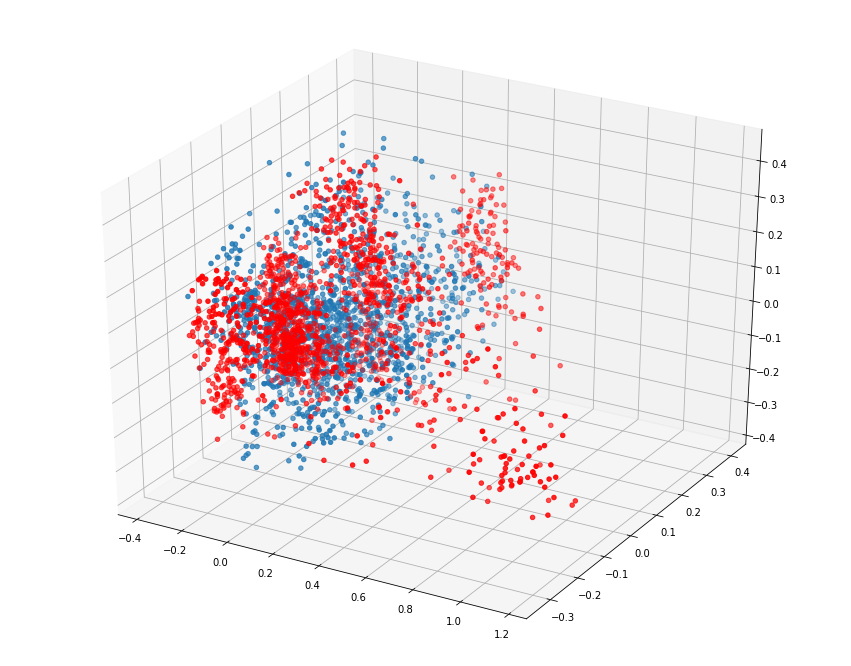

In [37]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(reduced_en[:,0], reduced_en[:,1], reduced_en[:,2])
ax.scatter(reduced_zh[:,0], reduced_zh[:,1], reduced_zh[:,2], c='red')
plt.show()

Here we try to plot a selection of tokens to see if their translation is nearby in the reduced space.

This sub-section is created with reference to this [demo](https://github.com/facebookresearch/MUSE/blob/main/demo.ipynb) by MUSE.

In [38]:
en_selection = ['cat', 'dog','school', 'home', 'sweden', 'norway', 'car', 'airplane', 'man', 'woman', 'basketball', 'volleyball', 'tennis']
zh_selection = ['猫', '狗', '学校', '家', '瑞典', '挪威', '车', '飞机', '男人', '女人', '篮球', '排球', '网球']

en_sel_vecs = embedding[en_selection]
zh_sel_vecs = zh_embedding[zh_selection]
pca2d = decomposition.PCA(n_components=2)
reduced_en_sel = pca2d.fit_transform(en_sel_vecs)
reduced_zh_sel = pca2d.fit_transform(zh_sel_vecs)

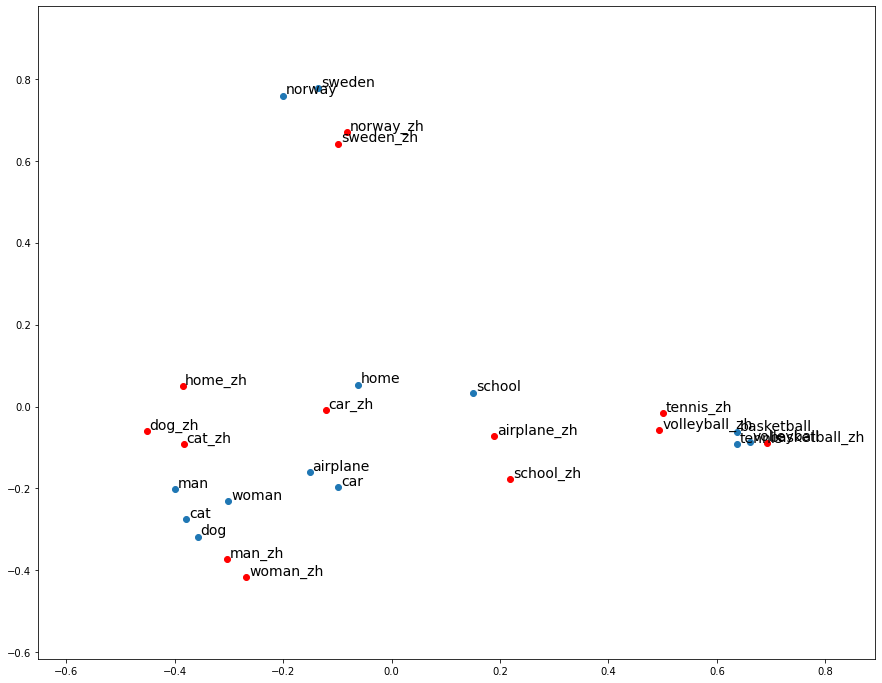

In [39]:
en_sel_tran = np.transpose(reduced_en_sel)
zh_sel_tran = np.transpose(reduced_zh_sel)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot()
ax.scatter(en_sel_tran[0], en_sel_tran[1])
ax.scatter(zh_sel_tran[0], zh_sel_tran[1], c='red')

for i, word in enumerate(en_selection): 
    ax.annotate(word, xy=(reduced_en_sel[i,0]+0.005, reduced_en_sel[i,1]+0.005), fontsize=14)
# I can't figure out a way to load the fonts for Chinese.
for i, word in enumerate(en_selection): 
    ax.annotate(word+'_zh', xy=(reduced_zh_sel[i,0]+0.005, reduced_zh_sel[i,1]+0.005), fontsize=14)

plt.xlim(min(en_sel_tran[0].min(), zh_sel_tran[0].min()) - 0.2, max(en_sel_tran[0].max(), zh_sel_tran[0].max()) + 0.2)
plt.ylim(min(en_sel_tran[1].min(), zh_sel_tran[1].min()) - 0.2, max(en_sel_tran[1].max(), zh_sel_tran[1].max()) + 0.2)
plt.show()

We can see that similar concepts are close by (sports, locations, animals and countries cluster together to some extent). Although we are using aligned embeddings here, the embeddings of Chinese translations do not seem that near to their source language counterpart.

## Comments

Completing the `Embedding` class was straightforward. Customizing the dunder methods were interesting. The first challenge is storing the vectors. Storing tokens and their vectors together (e.g. in a dictionary) maxes out the RAM, while not extracting the vectors in `__init__` and fetching for them subsequently may save space, but slows down the process in later sections of the assignment. Storing all vectors in an array and all tokens in a separate list is the optimal approach, and compatible with the other methods as well.

In the Word Analogies section, we tried out some adjectives, and the results are as expected. The first analogy (Japan in Asia) is more abstract, and it is interesting to see France, Germany and Belgium: is the analogy based on political power? Economy? Relative size? It will be hard to uncover.

The second part (gender analogies) is discussed in text between the codes and in the slides.

The third part (PCA) has roughly shown the mappings of related words (genders, sports) and their translations in the reduced space.